# Diagnosis: y_hit_down_24h_ge_0.01 vs HMM Variant

This notebook compares the baseline model and the HMM-augmented model for the `y_hit_down_24h_ge_0.01` target. It inspects prediction distributions, feature importance, and evaluation metrics across train/val/test splits.


## Checklist

1. Compare `y_true` / `y_pred` distributions across train, validation, and test splits.
2. Review top-20 gain-based feature importance rankings per model.
3. Collect AUC, PR AUC, and Brier scores by split for both models.

Additional notes:
- Metrics reported in `metrics.json` are captured alongside recomputed values from the prediction CSVs.
- Plots use the same bins and ranges to make the two models directly comparable.


In [51]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)


In [52]:
BASE_DIR = Path('/Volumes/Extreme SSD/trading_data/cex/models/BINANCE_BTCUSDT.P, 60/diagnosis')
MODELS = {
    'baseline': BASE_DIR / 'y_hit_up_24h_ge_0.04',
    'hmm': BASE_DIR / 'y_hit_up_24h_ge_0.04_hmm',
}
SPLITS = ['train', 'val', 'test']

for label, path in MODELS.items():
    if not path.exists():
        raise FileNotFoundError(f"Missing expected model folder: {path}")


In [53]:
predictions = {}
for label, path in MODELS.items():
    predictions[label] = {}
    for split in SPLITS:
        csv_path = path / f'pred_{split}.csv'
        df = pd.read_csv(csv_path)
        predictions[label][split] = df
        print(f"Loaded {label} {split}: {df.shape[0]} rows")


Loaded baseline train: 15554 rows
Loaded baseline val: 3333 rows
Loaded baseline test: 3334 rows
Loaded hmm train: 15201 rows
Loaded hmm val: 3257 rows
Loaded hmm test: 3259 rows


In [54]:
# peek at the head of each prediction file
for label in predictions:
    for split in SPLITS:
        display(
            predictions[label][split]
            .head()
            .assign(model=label, split=split)
        )


,timestamp,y_true,y_pred,model,split
0,2023-01-29 00:00:00+00:00,0.0,0.076829,baseline,train
1,2023-01-29 01:00:00+00:00,0.0,0.076829,baseline,train
2,2023-01-29 02:00:00+00:00,0.0,0.075416,baseline,train
3,2023-01-29 03:00:00+00:00,0.0,0.075416,baseline,train
4,2023-01-29 04:00:00+00:00,0.0,0.081020,baseline,train


,timestamp,y_true,y_pred,model,split
0,2024-11-07 02:00:00+00:00,0.0,0.093750,baseline,val
1,2024-11-07 03:00:00+00:00,0.0,0.096602,baseline,val
2,2024-11-07 04:00:00+00:00,0.0,0.096537,baseline,val
3,2024-11-07 05:00:00+00:00,0.0,0.096537,baseline,val
4,2024-11-07 06:00:00+00:00,0.0,0.096537,baseline,val


,timestamp,y_true,y_pred,model,split
0,2025-03-25 23:00:00+00:00,0.0,0.161812,baseline,test
1,2025-03-26 00:00:00+00:00,0.0,0.135387,baseline,test
2,2025-03-26 01:00:00+00:00,0.0,0.132897,baseline,test
3,2025-03-26 02:00:00+00:00,0.0,0.135387,baseline,test
4,2025-03-26 03:00:00+00:00,0.0,0.132897,baseline,test


,timestamp,y_true,y_pred,model,split
0,2023-01-31 00:00:00+00:00,0.0,0.147813,hmm,train
1,2023-01-31 01:00:00+00:00,0.0,0.147813,hmm,train
2,2023-01-31 02:00:00+00:00,0.0,0.147813,hmm,train
3,2023-01-31 03:00:00+00:00,0.0,0.147813,hmm,train
4,2023-01-31 04:00:00+00:00,0.0,0.150636,hmm,train


,timestamp,y_true,y_pred,model,split
0,2024-10-25 09:00:00+00:00,0.0,0.093567,hmm,val
1,2024-10-25 10:00:00+00:00,0.0,0.093567,hmm,val
2,2024-10-25 11:00:00+00:00,0.0,0.092976,hmm,val
3,2024-10-25 12:00:00+00:00,0.0,0.156169,hmm,val
4,2024-10-25 13:00:00+00:00,0.0,0.155250,hmm,val


,timestamp,y_true,y_pred,model,split
0,2025-03-10 02:00:00+00:00,0.0,0.266896,hmm,test
1,2025-03-10 03:00:00+00:00,0.0,0.266896,hmm,test
2,2025-03-10 04:00:00+00:00,0.0,0.314087,hmm,test
3,2025-03-10 05:00:00+00:00,0.0,0.310899,hmm,test
4,2025-03-10 06:00:00+00:00,0.0,0.310899,hmm,test


In [55]:
summary_rows = []
for label, splits in predictions.items():
    for split, df in splits.items():
        row = {
            'model': label,
            'split': split,
            'rows': len(df),
            'positives': float(df['y_true'].sum()),
            'positive_rate': float(df['y_true'].mean()),
            'pred_mean': float(df['y_pred'].mean()),
            'pred_std': float(df['y_pred'].std()),
            'pred_min': float(df['y_pred'].min()),
            'pred_max': float(df['y_pred'].max()),
        }
        summary_rows.append(row)

distribution_summary = pd.DataFrame(summary_rows)
display(distribution_summary)


,model,split,rows,positives,positive_rate,pred_mean,pred_std,pred_min,pred_max
0,baseline,train,15554,1891.0,0.121576,0.121009,0.104965,0.043176,0.697388
1,baseline,val,3333,517.0,0.155116,0.143664,0.061629,0.044386,0.422960
2,baseline,test,3334,224.0,0.067187,0.103292,0.038484,0.043284,0.289777
3,hmm,train,15201,1835.0,0.120716,0.120564,0.101568,0.043734,0.608615
4,hmm,val,3257,508.0,0.155972,0.116581,0.054553,0.044075,0.330849
5,hmm,test,3259,289.0,0.088678,0.100961,0.048555,0.044721,0.350167


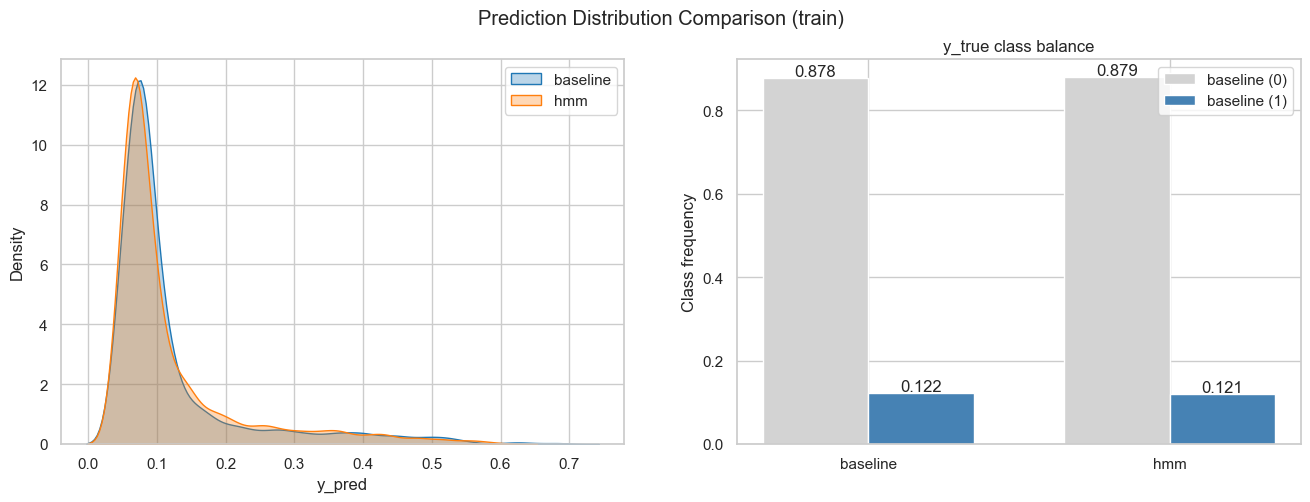

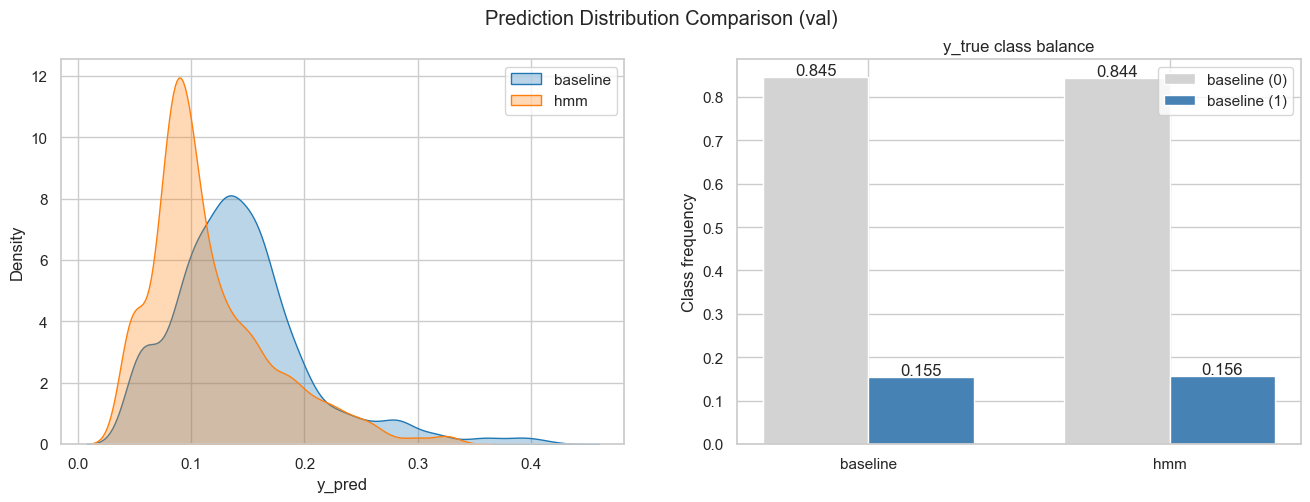

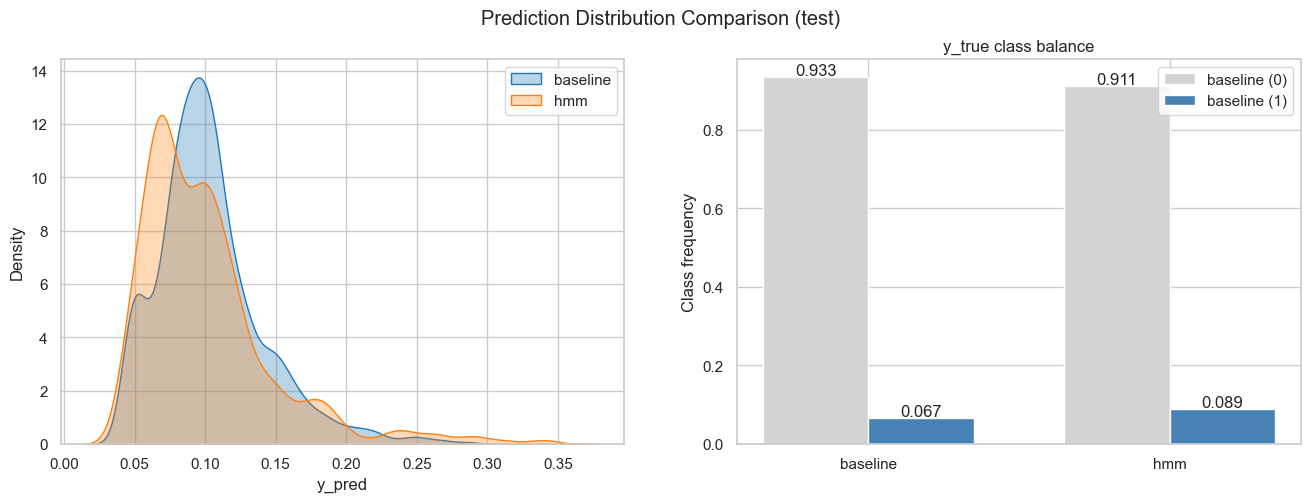

In [56]:
for split in SPLITS:
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    fig.suptitle(f"Prediction Distribution Comparison ({split})")

    # KDE / Histogram for predictions
    ax_pred = axes[0]
    for label, color in zip(MODELS.keys(), ['tab:blue', 'tab:orange']):
        sns.kdeplot(
            predictions[label][split]['y_pred'],
            ax=ax_pred,
            label=label,
            fill=True,
            alpha=0.3,
            color=color,
        )
    ax_pred.set_xlabel('y_pred')
    ax_pred.legend()

    # Bar plot for class balance
    ax_true = axes[1]
    width = 0.35
    x_positions = np.arange(len(MODELS))
    for idx, label in enumerate(MODELS.keys()):
        df = predictions[label][split]
        rates = df['y_true'].value_counts(normalize=True).sort_index()
        rates = rates.reindex([0, 1], fill_value=0)
        ax_true.bar(
            x_positions[idx] - width/2,
            rates.loc[0],
            width,
            label=f"{label} (0)" if idx == 0 else '',
            color='lightgrey'
        )
        ax_true.bar(
            x_positions[idx] + width/2,
            rates.loc[1],
            width,
            label=f"{label} (1)" if idx == 0 else '',
            color='steelblue'
        )
        ax_true.text(x_positions[idx] - width/2, rates.loc[0] + 0.005, f"{rates.loc[0]:.3f}", ha='center')
        ax_true.text(x_positions[idx] + width/2, rates.loc[1] + 0.005, f"{rates.loc[1]:.3f}", ha='center')
    ax_true.set_xticks(x_positions)
    ax_true.set_xticklabels(MODELS.keys())
    ax_true.set_ylabel('Class frequency')
    ax_true.set_title('y_true class balance')
    handles, labels = ax_true.get_legend_handles_labels()
    if handles:
        ax_true.legend(handles[:2], labels[:2])

    plt.show()


In [57]:
feature_tables = {}
for label, path in MODELS.items():
    fi_path = path / 'feature_importance.csv'
    fi = pd.read_csv(fi_path)
    fi = fi.sort_values('importance_gain', ascending=False)
    feature_tables[label] = fi

for label, fi in feature_tables.items():
    display(fi.head(20).assign(model=label))


,feature,importance_gain,importance_split,model
0,close_cvar_5_50_4H,6506.260075,40,baseline
1,time_dow_sin_1H,4492.121471,35,baseline
2,close_hv_20_12H,3517.303219,34,baseline
3,close_sma_20_12H,2300.265800,14,baseline
4,time_month_cos_1H,2090.471985,14,baseline
5,close_var_5_50_12H,2083.074387,17,baseline
6,close_var_5_50_4H,1995.899370,24,baseline
7,close_ma_cross_diff_5_20_12H,1701.943159,12,baseline
8,volume_sma_20_12H,1612.699474,16,baseline
9,close_amihud_20_1D,1610.975193,14,baseline


,feature,importance_gain,importance_split,model
0,close_hv_20_12H,3348.453995,35,hmm
1,time_dow_sin_1H,3102.459393,38,hmm
2,close_cvar_5_50_4H,2962.422497,27,hmm
3,close_var_5_50_12H,2232.833807,30,hmm
4,time_dow_cos_1H,999.447704,15,hmm
5,close_uo_7_14_28_12H,982.839808,13,hmm
6,time_day_of_month_1H,857.079895,15,hmm
7,time_month_cos_1H,853.265697,9,hmm
8,close_cum_return_5_12H,835.101402,11,hmm
9,close_amihud_20_1D,770.769209,8,hmm


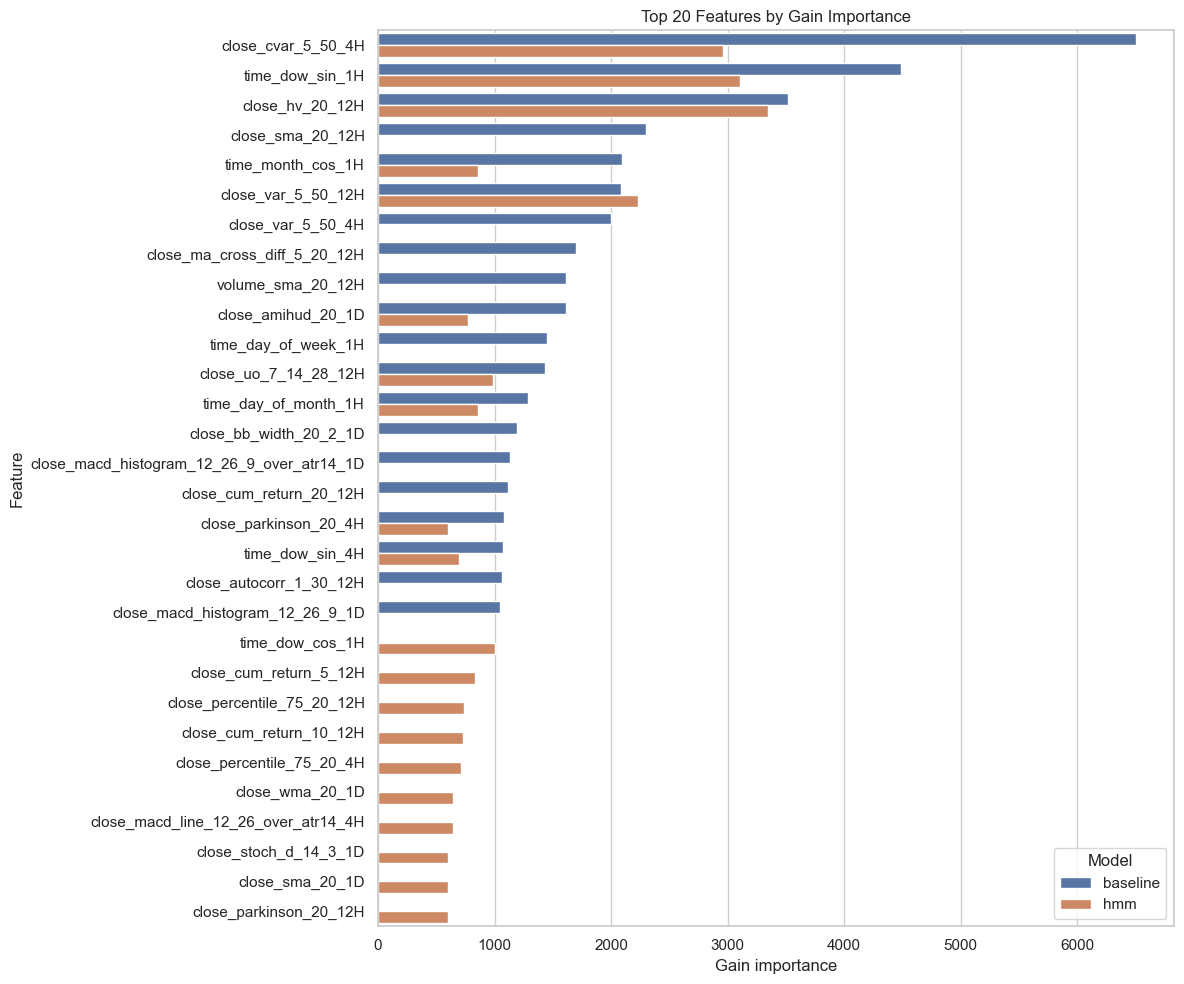

In [58]:
top_features = {}
for label, fi in feature_tables.items():
    top = fi.sort_values('importance_gain', ascending=False).head(20)
    top_features[label] = top

combined = pd.concat(
    [df.assign(model=label, rank=np.arange(1, len(df) + 1))
     for label, df in top_features.items()],
    ignore_index=True,
)

plt.figure(figsize=(12, 10))
ax = sns.barplot(
    data=combined,
    x='importance_gain',
    y='feature',
    hue='model'
)
ax.set_title('Top 20 Features by Gain Importance')
ax.set_xlabel('Gain importance')
ax.set_ylabel('Feature')
plt.legend(title='Model')
plt.tight_layout()
plt.show()


In [59]:
metrics_rows = []
for label, path in MODELS.items():
    metrics_path = path / 'metrics.json'
    metrics_data = json.loads(metrics_path.read_text())

    for split in SPLITS:
        df = predictions[label][split]
        y_true = df['y_true'].values
        y_pred = df['y_pred'].values

        result = {
            'model': label,
            'split': split,
            'auc_reported': metrics_data.get(f'auc_{split}', np.nan),
        }

        try:
            result['auc_recomputed'] = metrics.roc_auc_score(y_true, y_pred)
        except ValueError:
            result['auc_recomputed'] = np.nan

        try:
            result['pr_auc'] = metrics.average_precision_score(y_true, y_pred)
        except ValueError:
            result['pr_auc'] = np.nan

        result['brier_score'] = metrics.brier_score_loss(y_true, y_pred)
        metrics_rows.append(result)

metrics_df = pd.DataFrame(metrics_rows)
metrics_df = metrics_df.sort_values(['split', 'model']).reset_index(drop=True)
display(metrics_df)


,model,split,auc_reported,auc_recomputed,pr_auc,brier_score
0,baseline,test,0.746197,0.746197,0.140150,0.061750
1,hmm,test,0.738786,0.738786,0.215118,0.076629
2,baseline,train,0.977697,0.977697,0.893686,0.062492
3,hmm,train,0.962329,0.962329,0.829532,0.066353
4,baseline,val,0.663642,0.663642,0.302919,0.123850
5,hmm,val,0.630757,0.630757,0.286191,0.127879


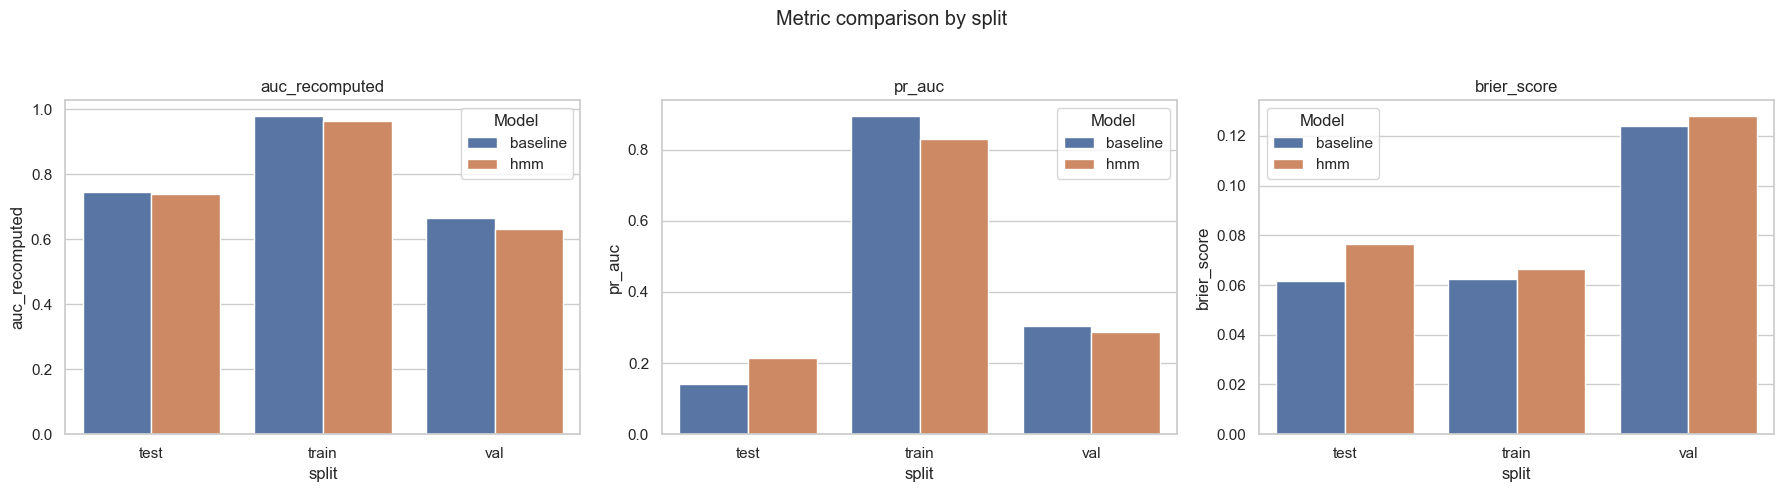

In [60]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)
for ax, metric_name in zip(axes, ['auc_recomputed', 'pr_auc', 'brier_score']):
    sns.barplot(
        data=metrics_df,
        x='split',
        y=metric_name,
        hue='model',
        ax=ax
    )
    ax.set_title(metric_name)
    ax.legend(title='Model')
plt.suptitle('Metric comparison by split')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


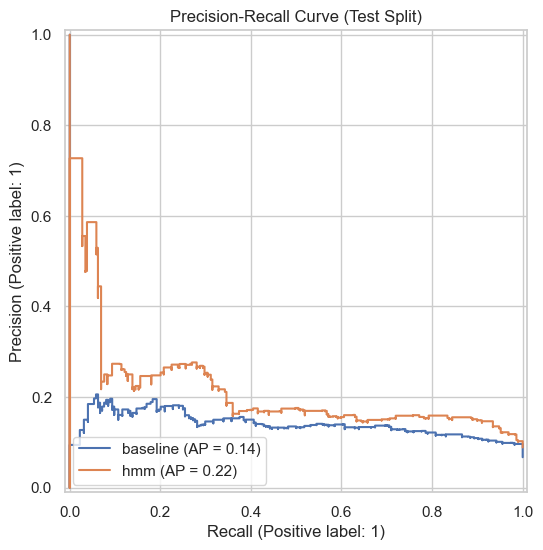

In [61]:
from sklearn.metrics import PrecisionRecallDisplay

fig, ax = plt.subplots(figsize=(8, 6))
for label in MODELS:
    y_true = predictions[label]['test']['y_true']
    y_pred = predictions[label]['test']['y_pred']
    PrecisionRecallDisplay.from_predictions(
        y_true,
        y_pred,
        name=label,
        ax=ax,
    )
ax.set_title('Precision-Recall Curve (Test Split)')
plt.show()


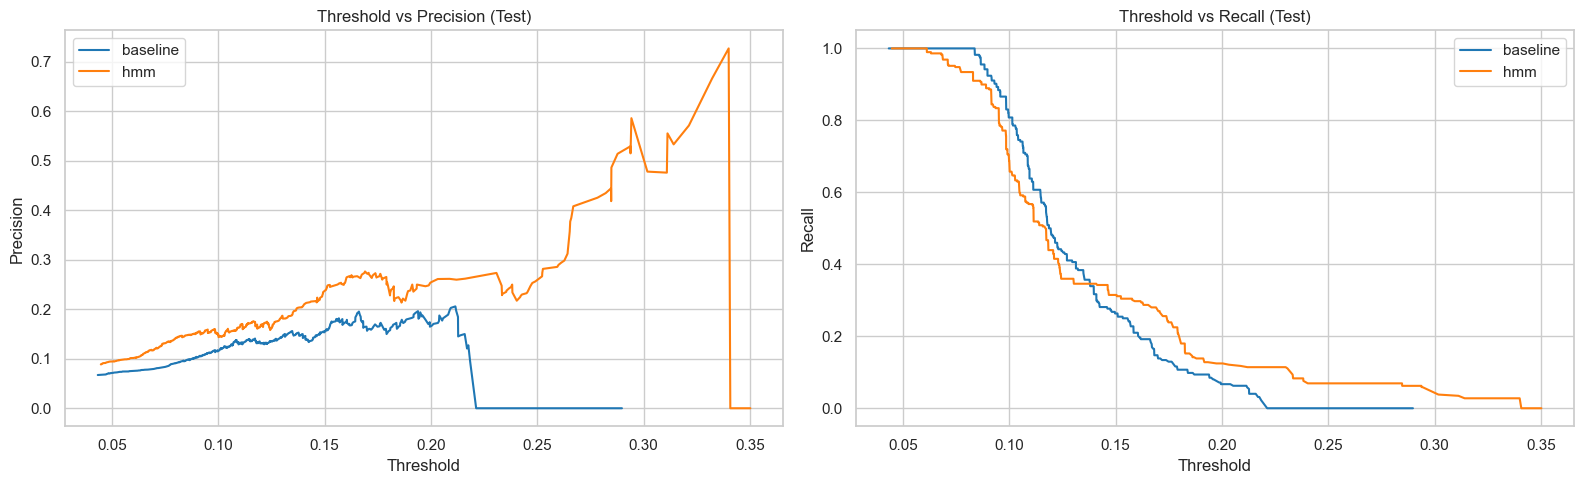

In [62]:
from sklearn.metrics import precision_recall_curve

fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=False)
for label, color in zip(MODELS.keys(), ['tab:blue', 'tab:orange']):
    y_true = predictions[label]['test']['y_true']
    y_pred = predictions[label]['test']['y_pred']
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

    axes[0].plot(thresholds, precision[:-1], label=label, color=color)
    axes[1].plot(thresholds, recall[:-1], label=label, color=color)

axes[0].set_title('Threshold vs Precision (Test)')
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('Precision')
axes[0].legend()

axes[1].set_title('Threshold vs Recall (Test)')
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('Recall')
axes[1].legend()

plt.tight_layout()
plt.show()
